In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_val_predict,  KFold,  LeaveOneOut, StratifiedKFold
import numpy as np
from sklearn.model_selection import GroupKFold
import os
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

In [2]:
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats

In [3]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [4]:
import sys 
sys.path.append("/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
sys.path.insert(1, '/cellar/users/mpagadal/Data/scripts')

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import statsmodels.api as sm

In [6]:
import networkx as nx
from ndex2.nice_cx_network import NiceCXNetwork 
import ndex2.client as nc
import ndex2

In [7]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Load ICB RNA

In [8]:
with open('/nrnb/users/carterlab/immunotherapy-trials/rna/all_immunotherapy_tpm.json', 'r') as f:
    icb_tpm = json.load(f)
rna=pd.DataFrame.from_dict(icb_tpm)

In [9]:
#normalize
rna+=1
rna=np.log2(rna)

In [10]:
rna.index=rna.index.str.split(".").str[0]

In [11]:
with open('/cellar/users/mpagadal/Data/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl = json.load(f)

In [12]:
ensembl={k.split(".")[0]:v for k,v in ensembl.items()}

In [13]:
rna["gene name"]=rna.index.map(ensembl)

In [14]:
rna=rna[~(rna["gene name"].isnull())]

In [15]:
rna.index=rna["gene name"]

In [16]:
del rna["gene name"]

In [17]:
rna=rna.T

In [18]:
rna.index=rna.index.str.split(".sra").str[0]

In [19]:
rna=rna.reset_index()

In [20]:
rna=rna.rename(columns={"index":"FID"})

## CIBERSORTx data

In [21]:
ciber=pd.read_csv("/cellar/users/mpagadal/Data2/cibersort/cibersortx-results/icb/LM22/CIBERSORTx_Results.txt",delimiter="\t")
ciber["Mixture"]=ciber["Mixture"].str.split(".sra").str[0]

In [22]:
del ciber["P-value"]
del ciber["Correlation"]
del ciber["RMSE"]

In [23]:
ciber=ciber.rename(columns={"Mixture":"FID"})

In [24]:
rna=pd.merge(rna,ciber,on="FID")

## Map to genotype ids

In [25]:
#get mapping file
mapping=pd.read_csv("/nrnb/users/carterlab/immunotherapy-trials/wxs_rna_mapping_table.tsv",delimiter="\t")
mapping=mapping[~(mapping["tumor RNA id"].isnull())]
mp_geno2rna=dict(zip(mapping["tumor RNA id"],mapping["normal WXS id"]))

In [26]:
len(mp_geno2rna)

192

## Format RNA for analysis

In [27]:
mp_study=dict(zip(mapping["tumor RNA id"],mapping["study"]))
mp_time=dict(zip(mapping["tumor RNA id"],mapping["Biopsy Time"]))

In [28]:
rna["study"]=rna["FID"].map(mp_study)
rna["time"]=rna["FID"].map(mp_time)

In [29]:
rna["FID"]=rna["FID"].map(mp_geno2rna)

In [30]:
rna_filt=rna[~(rna["FID"].isnull())]

In [31]:
print(rna_filt.shape)
rna_filt.head()

(191, 54783)


,FID,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,...,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,study,time
0,SRR5134823.sra,3.523562,2.454176,5.573799,2.720278,1.906891,3.528571,6.393176,5.484138,4.112700,...,0.108688,0.299984,0.011931,0.000000,0.033004,0.0,0.0,0.014174,riaz,Pre
4,SRR6504839.sra,2.963474,0.189034,4.379898,2.622930,3.450221,4.001802,4.394377,3.305971,4.775051,...,0.003920,0.106944,0.000000,0.012845,0.013077,0.0,0.0,0.048094,miao,NaN
5,SRR2724351.sra,2.910733,0.214125,5.054414,2.192194,3.877744,0.575312,3.276497,3.606442,5.234578,...,0.000000,0.163834,0.000000,0.000000,0.183785,0.0,0.0,0.000000,vanallen,NaN
6,SRR5134772.sra,5.523562,0.400538,6.285217,3.496974,3.292782,3.150560,6.692790,6.029453,4.710393,...,0.184764,0.230282,0.000000,0.000000,0.035843,0.0,0.0,0.002949,riaz,On
7,SRR6511550.sra,4.938756,0.000000,4.642124,1.448901,0.659925,4.427606,4.554589,4.929318,2.881665,...,0.047029,0.085136,0.000000,0.006823,0.071966,0.0,0.0,0.129841,miao,NaN


## Get ICB snps

In [32]:
icb=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/data/icb-snps.tsv",delimiter="\t")
odds=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/disease-relevance/data/TIME.icb.OR.tsv",delimiter="\t",header=None,skiprows=[2])

In [33]:
odds.columns = (odds.iloc[0] + '_' + odds.iloc[1])
odds.rename(columns={ odds.columns[0]: "ID" }, inplace = True)

In [34]:
odds=odds.iloc[2:,:]

In [35]:
odds["ID_noallele"]=odds["ID"].str.rsplit(":",2).str[0]
icb["ID_noallele"]=icb["MarkerName"].str.rsplit(":",2).str[0]

In [36]:
icb_odds=pd.merge(icb,odds,on="ID_noallele",how="left")

In [173]:
genes=icb_odds[icb_odds["-log10(fdr)"]>1]["file"].unique().tolist()

### trained model for complete response prediction 

In [38]:
mp_response=dict(zip(mapping["normal WXS id"],mapping["partial.sd.coding"]))

In [39]:
rna_filt["response"]=rna_filt["FID"].map(mp_response)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [134]:
rna_pre=rna_filt[~rna_filt["time"].isin(["On","on-treatment"])]

riaz
Area under the ROC curve : 0.561538
miao
Area under the ROC curve : 0.638889
vanallen
Area under the ROC curve : 0.506667
hugo
Area under the ROC curve : 0.571429


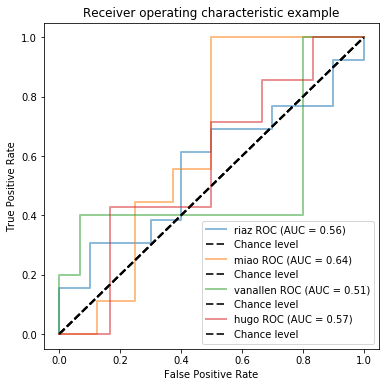

In [149]:
for x in rna_pre["study"].unique():
    print(x)
    rna_pre_study=rna_pre[(rna_pre["study"]==x)]
    
    X_train, X_test, y_train, y_test = train_test_split(rna_pre_study[genes], rna_pre_study["response"], test_size=.5,
                                                    random_state=3)
    
    clf = SVC(kernel='poly',probability=True, random_state=0,degree=3)

    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1],pos_label=2)
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)


    plt.figure(1, figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label=x+' ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
        

Area under the ROC curve : 0.584516


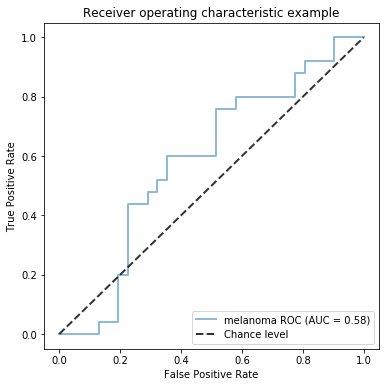

In [177]:
    rna_pre_study=rna_pre[~(rna_pre["study"]=="miao")]
    
    X_train, X_test, y_train, y_test = train_test_split(rna_pre_study[genes], rna_pre_study["response"], test_size=.5,
                                                    random_state=3)
    
    clf = SVC(kernel='rbf',probability=True, random_state=0,degree=3)

    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1],pos_label=2)
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)


    plt.figure(1, figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='melanoma ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
        

Area under the ROC curve : 0.638889


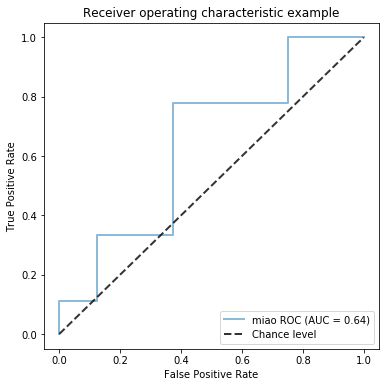

In [176]:
    rna_pre_study=rna_pre[(rna_pre["study"]=="miao")]
    
    X_train, X_test, y_train, y_test = train_test_split(rna_pre_study[genes], rna_pre_study["response"], test_size=.5,
                                                    random_state=3)
    
    clf = SVC(kernel='rbf',probability=True, random_state=0,degree=3)

    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1],pos_label=2)
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)


    plt.figure(1, figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='miao ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
        

In [164]:
genes=["LYZ","B2M"]

Area under the ROC curve : 0.405161


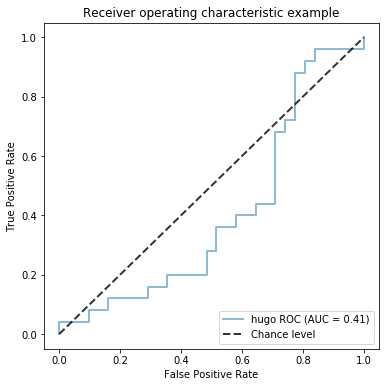

In [167]:
    rna_pre_study=rna_pre[~(rna_pre["study"]=="miao")]
    
    X_train, X_test, y_train, y_test = train_test_split(rna_pre_study[genes], rna_pre_study["response"], test_size=.5,
                                                    random_state=3)
    
    clf = SVC(kernel='linear',probability=True, random_state=0,degree=3)

    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1],pos_label=2)
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)


    plt.figure(1, figsize=(6,6))
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label=x+' ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
        